# 一、集成学习的主要方法

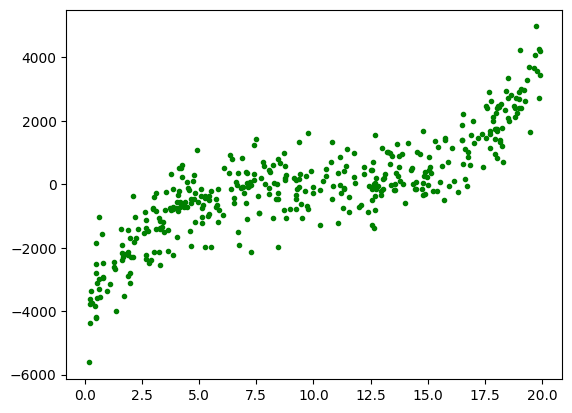

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
np.random.seed = 42
m = 400
X = np.random.rand(m,1)*20
y = 4 * (X-10)**3+10  #多项式特征
y = y+np.random.randn(m,1)*700

plt.plot(X,y,"g.") # 'g.'表示用蓝色的点来表示每个数据点

### 平均法

In [16]:
from sklearn.preprocessing import PolynomialFeatures  # 从sklearn库导入多项式特征生成器
from sklearn.linear_model import LinearRegression  # 从sklearn库导入线性回归模型

# 生成200个点的测试数据，这些点在X的最小值和最大值之间均匀分布
# reshape(-1,1)的作用是将数据转换成列向量
X_test = np.linspace(X.min(), X.max(), 200).reshape(-1, 1)

#训练集转换为多项式特征
X_poly1=PolynomialFeatures(degree=10).fit_transform(X)  #保证数据多样性
X_poly2=PolynomialFeatures(degree=20).fit_transform(X)
X_poly3=PolynomialFeatures(degree=30).fit_transform(X)

#创建三个线性回归模型
reg1,reg2,reg3=LinearRegression(),LinearRegression(),LinearRegression()
#进行计算
reg1.fit(X_poly1,y)
reg2.fit(X_poly2,y)
reg3.fit(X_poly3,y)

LinearRegression()

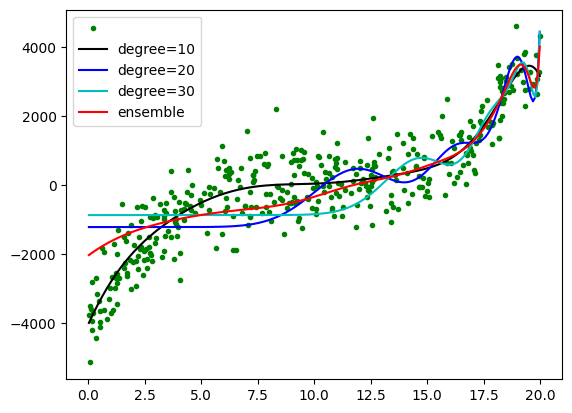

In [28]:
#测试集以同样的方式的转换为多项式特征
X_poly1_test=PolynomialFeatures(degree=10).fit_transform(X_test)  #保证数据多样性
X_poly2_test=PolynomialFeatures(degree=20).fit_transform(X_test)
X_poly3_test=PolynomialFeatures(degree=30).fit_transform(X_test)

#对每一个模型进行预测
y_pred1=reg1.predict(X_poly1_test)
y_pred2=reg2.predict(X_poly2_test)
y_pred3=reg3.predict(X_poly3_test)
#结果取平均，因为是平均法
y_ens=(y_pred1+y_pred2+y_pred3)/3
y_ens.shape

# 画出模型的拟合结果
plt.plot(X,y,"g.",label=" ")  #原数据
plt.plot(X_test,y_pred1,"k-",label="degree=10")
plt.plot(X_test,y_pred2,"b-",label="degree=20")
plt.plot(X_test,y_pred3,"c-",label="degree=30")
plt.plot(X_test,y_ens,"r-",label="ensemble")
plt.legend(loc="upper left")

# 二、集成学习方法

### 投票法

In [61]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

# 生成模拟数据
X, y = make_moons(n_samples=500, noise=0.3, random_state=42)  
# 使用make_moons函数生成500个样本，这些样本形成"moon-shaped"数据集，noise参数控制数据的噪声水平，random_state保证每次运行代码时生成的数据都相同

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

####预投票
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

#创建不同的模型
log_clf = LogisticRegression(solver='liblinear')
svm_clf = SVC(gamma="auto")   #svc只能用硬投票
rnd_clf = RandomForestClassifier(criterion='gini')
#选择硬投票
voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('svc', svm_clf),('rnd',rnd_clf)],
    voting='hard')  #'hard','soft'
for clf in (svm_clf, rnd_clf,log_clf, voting_clf):
    clf.fit(X_train,y_train)
    y_pre=clf.predict(X_test)
    print(clf.__class__.__name__,f"的准确率为：{accuracy_score(y_test,y_pre)*100:.2f}%")

SVC 的准确率为：91.33%
RandomForestClassifier 的准确率为：89.33%
LogisticRegression 的准确率为：86.00%
VotingClassifier 的准确率为：91.33%


In [69]:
###软投票：基于类别概率
#创建不同的模型
log_clf = LogisticRegression()
svc_clf = SVC(probability=True)  #不设probability=True会报错
rnd_clf = RandomForestClassifier()
#选择软投票
voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('svc', svc_clf),('rnd',rnd_clf)],
    voting='soft')  #'hard','soft'
for clf in (svc_clf, rnd_clf,log_clf, voting_clf):
    clf.fit(X_train,y_train)
    y_pre=clf.predict(X_test)
    print(clf.__class__.__name__,f"的准确率为：{accuracy_score(y_test,y_pre)*100:.2f}%")

SVC 的准确率为：90.67%
RandomForestClassifier 的准确率为：89.33%
LogisticRegression 的准确率为：86.00%
VotingClassifier 的准确率为：92.67%


# 二、集成学习方法

## 2.1 打包算法

In [95]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
from sklearn.metrics import accuracy_score

# 生成模拟数据
X, y = make_moons(n_samples=500, noise=0.3, random_state=42)  
# 使用make_moons函数生成500个样本，这些样本形成"moon-shaped"数据集，noise参数控制数据的噪声水平，random_state保证每次运行代码时生成的数据都相同
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

# 创建一个BaggingClassifier
clf=BaggingClassifier(estimator=DecisionTreeClassifier(random_state=42), #基分类器用决策树
                        n_estimators=500,  #创建500个决策树分类器
                        max_samples=100,  #每个基分类器可以使用的最大样本数量作为训练
                        max_features=1.0,  
                        bootstrap=True,    #是否放回抽样，以此决定是打包还是粘贴
                        n_jobs=-1,      #-1表示使用所有线程来训练，其他表示并行数量设置为x
                        random_state=42).fit(X_train,y_train)
y_pre=clf.predict(X_test)
print(f"打包算法的准确率为：{accuracy_score(y_test,y_pre)*100:.2f}%")

打包算法的准确率为：92.00%


In [96]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
tree=DecisionTreeClassifier(random_state=42).fit(X_train,y_train)
y_pre=tree.predict(X_test)
print(f"原本决策树的准确率为：{accuracy_score(y_test,y_pre)*100:.2f}%")

原本决策树的准确率为：85.33%


## 2.2 随机森林

In [110]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
from sklearn.metrics import accuracy_score

# 生成模拟数据
X, y = make_moons(n_samples=500, noise=0.3, random_state=42)  
# 使用make_moons函数生成500个样本，这些样本形成"moon-shaped"数据集，noise参数控制数据的噪声水平，random_state保证每次运行代码时生成的数据都相同
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

# 创建一个RandomForestClassifier
rnd_clf=RandomForestClassifier(n_estimators=500,  #创建500个决策树分类器
                        criterion='gini',
                        max_depth=10,
                        min_samples_split=2,
                        min_samples_leaf=1,
                        min_weight_fraction_leaf=0.0,
                        max_leaf_nodes=16,  #最大叶子节点数
                        bootstrap=True,  #有放回
                        oob_score=False,
                        n_jobs=-1,
                        random_state=42).fit(X_train,y_train)
y_pre=rnd_clf.predict(X_test)
print(f"随机森林的准确率为：{accuracy_score(y_test,y_pre)*100:.2f}%")

随机森林的准确率为：91.33%


## 2.3 自适应提升法 AdaBoost

In [130]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# 生成模拟数据
X, y = make_moons(n_samples=500, noise=0.3, random_state=42)  
# 使用make_moons函数生成500个样本，这些样本形成"moon-shaped"数据集，noise参数控制数据的噪声水平，random_state保证每次运行代码时生成的数据都相同
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

# 创建AdaBoostClassifier
clf=AdaBoostClassifier(estimator=DecisionTreeClassifier(),  #决策树作为基本估计器
                        n_estimators=500,  #训练基本估计器的数量
                        algorithm="SAMME.R",
                        learning_rate=0.5,  # 弱学习器的权重。学习率决定了每一个基本估计器最终组合的贡献，较低的值需要更多的估计器
                        random_state=42).fit(X_train,y_train)
y_pre=clf.predict(X_test)
print(f"随机森林的准确率为：{accuracy_score(y_test,y_pre)*100:.2f}%")

随机森林的准确率为：87.33%


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


# 作业
#### 读取手写digits数据集，完成如下操作：
#### 1、对数据集做预处理（比如：筛选特征，缺失值处理，one-hot encoding，标准化处理和数据划分等）
#### 2、训练决策树模型，并绘制ROC曲线评价模型。
#### 3、训练随机森林模型，并绘制ROC曲线评价模型。（两个模型的ROC曲线绘制到一张图里）

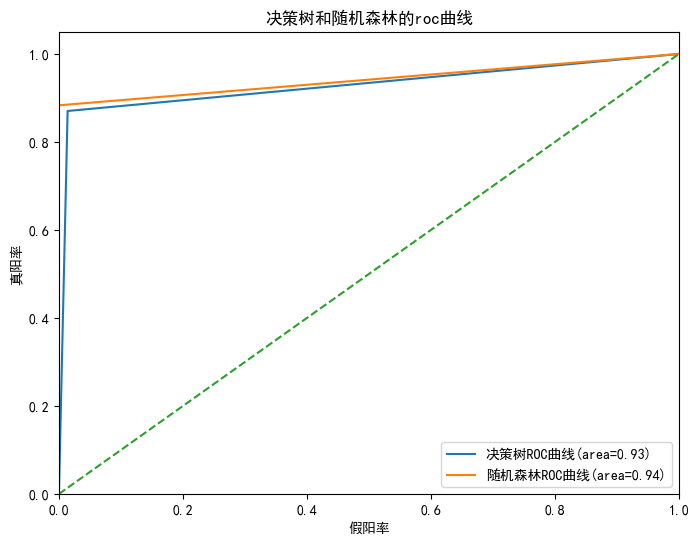

随机森林的准确率为77.22%
随机森林的准确率为88.33%


In [10]:
# 1. 导入库
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.multiclass import OneVsOneClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.datasets import load_digits
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score
from sklearn import metrics
plt.rcParams['font.sans-serif'] = 'SimHei'#宋体，显示中文
plt.rcParams['axes.unicode_minus'] = False

#### 1、对数据集做预处理（比如：筛选特征，缺失值处理，one-hot encoding，标准化处理和数据划分等）
digits=load_digits()
X,y=digits.data,digits.target
#将标签二值化,one-hot encoding
y_binarize=label=label_binarize(y,classes=np.unique(y))
#数据标准化
scaler=StandardScaler()
X_scaled=scaler.fit_transform(X)
#划分数据集
X_train,X_test,y_train,y_test = train_test_split(X_scaled,y_binarize,test_size=.3,random_state=42)

#### 2、训练模型
#用OneVsRestClassifier分类器来封装决策树模型，因为标准的ROC通常用于二分类
#对每一个类别，创建相应的二分类器，这样每一个类别就有自己的类别概率
tree_clf=OneVsRestClassifier(DecisionTreeClassifier()).fit(X_train,y_train)
rand_clf=OneVsRestClassifier(RandomForestClassifier()).fit(X_train,y_train)
y_tree=tree_clf.predict(X_test)
y_rand=rand_clf.predict(X_test)

fpr_tree,tpr_tree,_=metrics.roc_curve(y_test.ravel(),y_tree.ravel())
fpr_rand,tpr_rand,_=metrics.roc_curve(y_test.ravel(),y_rand.ravel())

#### 3、绘制ROC曲线评价模型。（两个模型的ROC曲线绘制到一张图里）
roc_tree=metrics.auc(fpr_tree,tpr_tree)
roc_rand=metrics.auc(fpr_rand,tpr_rand)

plt.figure(figsize=(8,6))
plt.plot(fpr_tree,tpr_tree,label="决策树ROC曲线(area=%.2f)" % roc_tree)
plt.plot(fpr_rand,tpr_rand,label="随机森林ROC曲线(area=%.2f)" % roc_rand)
plt.plot([0,1],[0,1],linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('假阳率')
plt.ylabel('真阳率')
plt.title('决策树和随机森林的roc曲线')
plt.legend(loc="lower right")
plt.show()

#4、计算准确率
print(f"随机森林的准确率为{accuracy_score(y_test,y_tree)*100:.2f}%")
print(f"随机森林的准确率为{accuracy_score(y_test,y_rand)*100:.2f}%")

In [ ]:
# mnist = sio.loadmat('datasets/mnist-original.mat')
# #print(mnist)
# x = mnist["data"].T
# y = mnist["label"].flatten()

# # 3. 划分训练集和测试集，并把训练集随机打乱
# x_train,x_test,y_train,y_test = x[:60000],x[60000:],y[:60000],y[60000:]
# print("打乱训练集前的目标数据为：",y_train)
# shuffle_index = np.random.permutation(60000)
# x_train,y_train = x_train[shuffle_index],y_train[shuffle_index]
# print("打乱训练集后的目标数据为：",y_train)

# # 4. 模型训练：梯度下降法的分类模型
# #一对多分类策略
# sgd_ovr=SGDClassifier(max_iter=5).fit(x_train,y_train)
# #一对一分类策略
# sgd_ovo=OneVsOneClassifier(SGDClassifier(max_iter=6)).fit(x_train,y_train)
# # 5. 模型预测
# ovr_pre=sgd_ovr.predict(x_test)  
# ovo_pre=sgd_ovo.predict(x_test)

# # 6. 模型评估
# #一对多策略
# acc=accuracy_score(y_test,ovr_pre)  
# pre=precision_score(y_test,ovr_pre, average='weighted')
# rel=recall_score(y_test,ovr_pre, average='weighted')
# f1=f1_score(y_test,ovr_pre, average='weighted')
# print("-----------------------一对多策略---------------------------\n\
# 正确率为：{:.2f}%\n\
# 精确率为：{:.2f}%\n\
# 查全率为：{:.2f}%\n\
# F1分数为：{:.2f}%\n"\
#       .format(acc*100,pre*100,rel*100,f1*100))
# #一对一策略
# acc=accuracy_score(y_test,ovo_pre)  
# pre=precision_score(y_test,ovo_pre, average='weighted')
# rel=recall_score(y_test,ovo_pre, average='weighted')
# f1=f1_score(y_test,ovo_pre, average='weighted')
# print("-----------------------一对一策略---------------------------\n\
# 正确率为：{:.2f}%\n\
# 精确率为：{:.2f}%\n\
# 查全率为：{:.2f}%\n\
# F1分数为：{:.2f}%\n"\
#       .format(acc*100,pre*100,rel*100,f1*100))

图中也包括了对角线，这条线代表随机猜测的性能，理想的模型其ROC曲线应远离并高于这条线，表现为向左上角弯曲。AUC（Area Under the Curve，曲线下面积）是衡量分类器性能的一个重要指标，它通过整合不同阈值下的TPR（True Positive Rate，真正率）和FPR（False Positive Rate，假阳性率）得出。AUC值介于0.5（等同于随机猜测）和1（完美分类）之间。AUC值越接近1，表示分类器的预测性能越好。在我们的案例中，通过对每个阈值下的TPR进行插值，并与对应的FPR计算得到的面积，我们获得了每个模型的AUC值，从而可以对其性能进行量化评估。